# Outlier detection

In [1]:
import numpy as np
import scipy.io as sio
import scipy.signal as signal
import scipy.stats
from scipy.interpolate import griddata
from matplotlib import pyplot as plt
import copy

# Required for interactive plots in DataSpell
# import matplotlib
# matplotlib.use("nbagg")

### Generating data

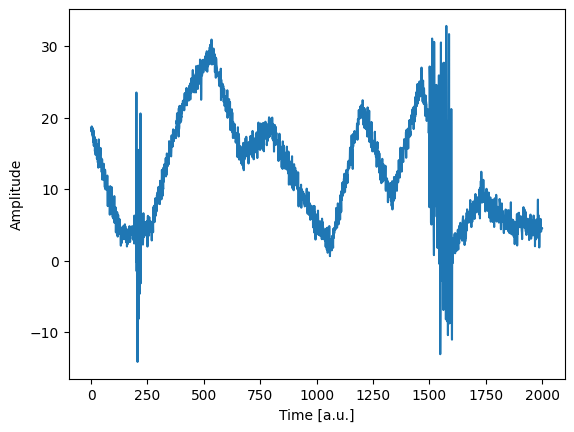

In [6]:
## generate signal with varying variability
n = 2000
p = 15  # poles for random interpolation

# amplitude modulator
signal1 = np.interp(np.linspace(0,p,n), np.arange(0,p), np.random.rand(p)*30)
signal1 = signal1 + np.random.randn(n)


# add some high-amplitude noise
signal1[200:221]   = signal1[200:221] + np.random.randn(21)*9
signal1[1500:1601] = signal1[1500:1601] + np.random.randn(101)*9


# plot
plt.plot(signal1)
plt.xlabel("Time [a.u.]")
plt.ylabel("Amplitude")
plt.show()

### Goal
Generate a figure that shows how changing the width of the sliding RMS window affect the result.

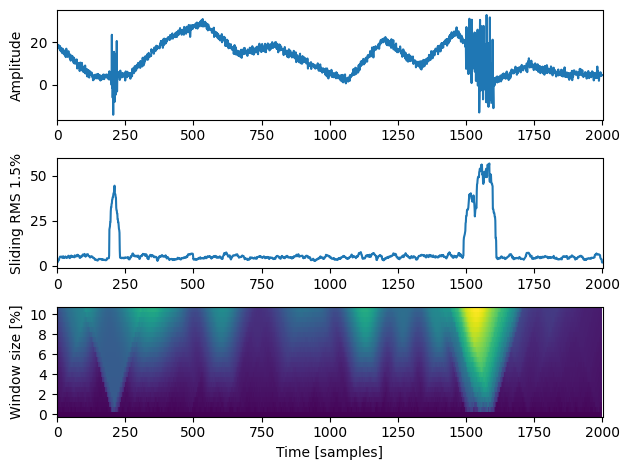

In [10]:
## detect bad segments using sliding RMS

# Range of window ranges to test (percentage!)
# pct_window_range = np.arange(1, 20, 0.1)
pct_window_range = np.arange(0, 11, 0.5)

# Matrix to save results in
rms_ts_ranges = []

for pct_win in pct_window_range:

    # convert to indices
    k = int(n * (pct_win/2/100))

    # initialize RMS time series vector
    rms_ts = np.zeros(n)

    for ti in range(0,n):

        # boundary points
        low_bnd = int( np.max((0,ti-k)) )
        upp_bnd = int( np.min((n,ti+k)) )

        # signal segment (and mean-center!)
        tmpsig = signal1[range(low_bnd,upp_bnd)]
        tmpsig = tmpsig - np.mean(tmpsig)

        # compute RMS in this window
        rms_ts[ti] = np.sqrt(np.sum( tmpsig**2 ))

    rms_ts_ranges.append(rms_ts)

rms_ts_ranges = np.array(rms_ts_ranges)

best_index = 2  # 1.5%
rms_signal = rms_ts_ranges[best_index]

plt.subplot(311)
plt.plot(signal1)
plt.ylabel("Amplitude")

plt.subplot(312, sharex=plt.gca())
plt.plot(rms_signal)
plt.ylabel("Sliding RMS 1.5%")

plt.subplot(313, sharex=plt.gca())
plt.pcolormesh(np.arange(n), pct_window_range, rms_ts_ranges)
plt.ylabel("Window size [%]")
plt.xlabel("Time [samples]")
plt.yticks(range(0, 12, 2))
plt.xticks(range(0, 2250, 250))

plt.tight_layout()
plt.show()

### Removing the noise
Visually, we can see that a window of 1.5% nicely encapsulates the data. Lets filter the data.

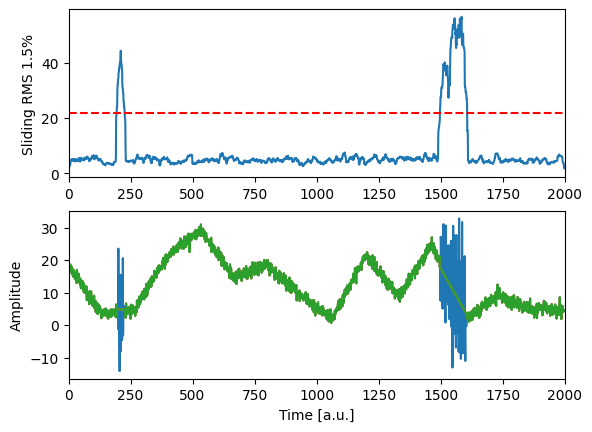

In [11]:
### Set threshold based on global standart deviation
threshold = np.mean(rms_signal) + 1.5 * np.std(rms_signal)

### Remove data
removeMask = rms_signal > threshold
cleanedSignal = np.delete(signal1, removeMask)
cleanedTime = np.delete(np.arange(0, 2000), removeMask)

### Interpolate empty spaces to fill vector
interpolSignal = griddata(cleanedTime, cleanedSignal, np.arange(0, 2000), method='linear')

plt.subplot(211)
plt.plot(rms_signal)
plt.hlines(threshold, 0, 2000, color='red', linestyles='dashed')
plt.xlim(0, 2000)
plt.ylabel("Sliding RMS 1.5%")

plt.subplot(212, sharex=plt.gca())
plt.plot(signal1)
plt.plot(cleanedTime, cleanedSignal)
plt.plot(interpolSignal)
plt.xlabel("Time [a.u.]")
plt.ylabel("Amplitude")


plt.show()


### Spectral interpolation
Nice, remove the noise! Now, lets use spectral interpolation to restore the signal. (note that the previous step is redundant and we could have applied spectral interpolation immediately)

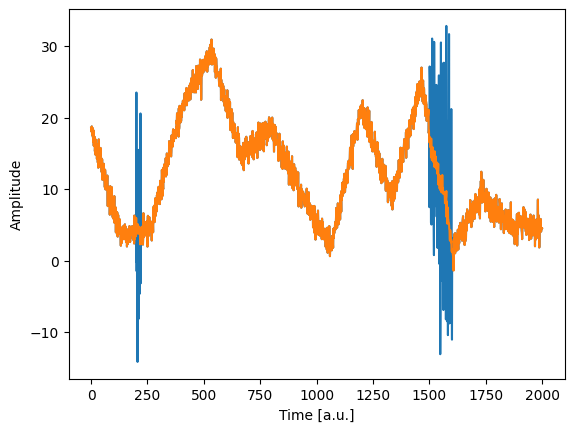

In [13]:
## Identify peaks
# First peak
start1 = np.argmax(removeMask)                      # Rising edge of first peak
end1   = np.argmin(removeMask[start1:]) + start1    # Falling edge of first peak

# Second peak
start2 = np.argmax(removeMask[end1:]) + end1        # Rising edge of first peak
end2   = np.argmin(removeMask[start2:]) + start2    # Falling edge of first peak

# Function to interpolate between _begin_ and _end_ in the _data_ array
def spectralInterpolation(data: np.ndarray, begin: int, end: int) -> np.ndarray:
    width = end - begin

    # Data before the section of interest
    beforeStart = begin - width
    beforeEnd = begin
    beforeData = data[beforeStart:beforeEnd]
    beforeFFT = np.fft.fft(beforeData)

    # Data after the section of interest
    afterStart = end
    afterEnd = end + width
    afterData = data[afterStart:afterEnd]
    afterFFT = np.fft.fft(afterData)

    # Average the spectrum
    interpolatedFFT = (beforeFFT + afterFFT) / 2
    interpolatedSignal = np.real(np.fft.ifft(interpolatedFFT))

    # Remove the existing trend
    mixeddata = signal.detrend(interpolatedSignal)

    # Create our own trend to connect the lines
    linedata = np.linspace(0, 1, width) * (data[end + 1] - data[begin - 1]) + data[begin - 1]

    # sum together for final result
    linterp = mixeddata + linedata

    # Overwrite existing signal
    data[begin:end] = linterp

    return data


## Correcting first peak
interpolSignal = spectralInterpolation(interpolSignal, start1, end1)

## Correcting second peak
interpolSignal = spectralInterpolation(interpolSignal, start2, end2)

plt.figure()
plt.plot(signal1)
plt.plot(interpolSignal)
plt.ylabel("Amplitude")
plt.xlabel("Time [a.u.]")
plt.show()


Nice! Looks like there was nothing wrong in the first place!